<a href="https://colab.research.google.com/github/waynemaranga/phoenixke-masterclass/blob/main/Capstone_Project_Group_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project Group 7
Dennis, Joan, Lisa and Wayne
The Best

## Imports

In [20]:
# Libraries to assist us
import requests
from bs4 import BeautifulSoup
import time
import csv # for csv file operations
import os # to access operating system

## Request Parameters
### Heading level 3
#### Heading level 4

This is **bold**

This is _italic_


In [21]:
BASE_URL = "http://books.toscrape.com/" # one base to request multiple URLs/pages without repeating too many times
HEADERS = {"User-Agent": "ScraperBotbyLisaDennisandWayne"} # a request header; carries info about the request; for scraping rules
SLEEP_TIME = 1  # seconds between requests; some delays for respecting sites

## Get html as string i.e soup

In [22]:
# -- A soup is a site's html as a string
def get_soup(url):
    try:
        response = requests.get(url, headers=HEADERS) # gets the HTML as raw html using the headers
        response.raise_for_status() # raises error if any with http error code
        return BeautifulSoup(response.text, "html.parser") # returns the soup and the parser to use

        # This except block handles any error with the requests function for example invalid urls
    except requests.exceptions.RequestException as e:
        print(f"[ERROR] Failed to fetch {url} - {e}")
        return None
    except Exception as ex:
      print(f"[ERROR] Encountered ambiguous error: - {ex}")
      return None

In [23]:
print(get_soup("www.facebook.com")) 

[ERROR] Failed to fetch www.facebook.com - Invalid URL 'www.facebook.com': No scheme supplied. Perhaps you meant https://www.facebook.com?
None


In [24]:
print(get_soup("https://www.facebooks.com"))

[ERROR] Failed to fetch https://www.facebooks.com - HTTPSConnectionPool(host='www.facebooks.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.facebooks.com'. (_ssl.c:1010)")))
None


In [25]:
print(str(get_soup("https://www.facebook.com"))[:99]) # this should work

<!DOCTYPE html>

<html class="no_js" id="facebook" lang="sw">
<head><meta charset="utf-8"/><meta co


In [26]:
# Not essential
def convert_star_rating(star_str):
    stars = {
        "One": 1, "Two": 2, "Three": 3,
        "Four": 4, "Five": 5
    }
    return stars.get(star_str, 0)

In [27]:
# -- This function is tailored the books to scrape site
def extract_product_info(product):
    try:
      # This information is got from inspecting the page using developer tools
      # Each item (likely) belongs in a tag, a nested tag or something close to it
      # 1. Inspect page 2. Inspect page using
        title = product.h3.a['title'].strip()
        relative_url = product.h3.a['href']
        product_url = BASE_URL + 'catalogue/' + relative_url.replace('../../../', '')
        price = product.select_one('.price_color').text.strip().replace('£', '') # .select_one(identifier) finds any html element using this identifier/class/attribute and returns a list or one item
        availability = product.select_one('.availability').text.strip()
        star_class = product.select_one('.star-rating')['class']
        star_rating = convert_star_rating(star_class[1]) # converts html star elements into a rating

        # Go to individual product page for verification or more details
        return {
            "Title": title,
            "Price": price,
            "Availability": availability,
            "Star Rating": star_rating,
            "URL": product_url
        }
        # handles any error
    except Exception as e: # uses Python's base Exception which handles all exceptions
        print(f"[ERROR] Failed to parse product info - {e}")
        return None

    except KeyboardInterrupt as k:
      return None

In [28]:
# Getting categories in the first place from homepage
def get_categories():
    soup = get_soup(BASE_URL) # get the soup of the homepage
    if not soup:
        return {}

    category_links = soup.select('.side_categories ul li ul li a') # from the soup get the list and urls of categories
    categories = {} # dictionary for category name and url
    for a in category_links:
        name = a.text.strip()
        rel_url = a['href'] # e.g '/catalogue/category/books_1/index.html'
        full_url = BASE_URL + rel_url # type: ignore # add base url to relative url : https://books.toscrape.com/catalogue/category/books_1/index.html
        categories[name] = full_url
    return categories



In [29]:
print(get_categories())

{'Travel': 'http://books.toscrape.com/catalogue/category/books/travel_2/index.html', 'Mystery': 'http://books.toscrape.com/catalogue/category/books/mystery_3/index.html', 'Historical Fiction': 'http://books.toscrape.com/catalogue/category/books/historical-fiction_4/index.html', 'Sequential Art': 'http://books.toscrape.com/catalogue/category/books/sequential-art_5/index.html', 'Classics': 'http://books.toscrape.com/catalogue/category/books/classics_6/index.html', 'Philosophy': 'http://books.toscrape.com/catalogue/category/books/philosophy_7/index.html', 'Romance': 'http://books.toscrape.com/catalogue/category/books/romance_8/index.html', 'Womens Fiction': 'http://books.toscrape.com/catalogue/category/books/womens-fiction_9/index.html', 'Fiction': 'http://books.toscrape.com/catalogue/category/books/fiction_10/index.html', 'Childrens': 'http://books.toscrape.com/catalogue/category/books/childrens_11/index.html', 'Religion': 'http://books.toscrape.com/catalogue/category/books/religion_12/i

In [30]:
# Since the page has many categories; for each category get it's soup
# Pagination function; made possible by inspection
def get_category_pages(category_url):
    pages = [category_url]
    soup = get_soup(category_url)
    if not soup:
        return []

    pager = soup.select_one('.current') # select current page
    if pager:
        total_pages = int(pager.text.strip().split()[-1]) # get no. of pages
        for page_num in range(2, total_pages + 1):
            paginated_url = category_url.replace('index.html', f'page-{page_num}.html') # replace current page with page no.s
            pages.append(paginated_url)
    return pages

In [31]:
print(get_category_pages("http://books.toscrape.com/catalogue/category/books/default_15/index.html"))

['http://books.toscrape.com/catalogue/category/books/default_15/index.html', 'http://books.toscrape.com/catalogue/category/books/default_15/page-2.html', 'http://books.toscrape.com/catalogue/category/books/default_15/page-3.html', 'http://books.toscrape.com/catalogue/category/books/default_15/page-4.html', 'http://books.toscrape.com/catalogue/category/books/default_15/page-5.html', 'http://books.toscrape.com/catalogue/category/books/default_15/page-6.html', 'http://books.toscrape.com/catalogue/category/books/default_15/page-7.html', 'http://books.toscrape.com/catalogue/category/books/default_15/page-8.html']


In [32]:
print(get_category_pages("http://books.toscrape.com/catalogue/category/books/sequential-art_5/index.html"))

['http://books.toscrape.com/catalogue/category/books/sequential-art_5/index.html', 'http://books.toscrape.com/catalogue/category/books/sequential-art_5/page-2.html', 'http://books.toscrape.com/catalogue/category/books/sequential-art_5/page-3.html', 'http://books.toscrape.com/catalogue/category/books/sequential-art_5/page-4.html']


In [33]:
# Scrape category...
def scrape_category(category_name, category_url):
    print(f"\n[INFO] Scraping category: {category_name}")
    all_data = []
    pages = get_category_pages(category_url) # all pages in category to be scraped

    for page_url in pages:
        print(f"[INFO] Scraping page: {page_url}")
        soup = get_soup(page_url) # get the soup
        if not soup:
            continue

        products = soup.select('article.product_pod') # find a product card
        for product in products:
            info = extract_product_info(product) # from product extract info e.g title and price
            if info:
                all_data.append(info)
        time.sleep(SLEEP_TIME)

    save_to_csv(category_name, all_data)

def save_to_csv(category, data):
    os.makedirs("output", exist_ok=True)
    filename = f"output/{category.replace(' ', '_').lower()}.csv"
    with open(filename, "w", newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=["Title", "Price", "Availability", "Star Rating", "URL"])
        writer.writeheader()
        for row in data:
            writer.writerow(row)
    print(f"[SUCCESS] Saved {len(data)} items to {filename}")


In [34]:
from pathlib import Path
WORKING_DIR: Path = Path().cwd()
print(f"Working Directory: {WORKING_DIR}")
OUTPUT_DIR: Path = WORKING_DIR / "output"
if OUTPUT_DIR.exists():
    print(f"Output Directory: {OUTPUT_DIR}")
else:
    print(f"Output Directory does not exist: {OUTPUT_DIR}")
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Output Directory created: {OUTPUT_DIR}")

Working Directory: /home/neo/Projects/phoenixke-masterclass/assignment-3
Output Directory: /home/neo/Projects/phoenixke-masterclass/assignment-3/output
Output Directory created: /home/neo/Projects/phoenixke-masterclass/assignment-3/output


In [35]:
def save_to_csv(category, data):
    # os.makedirs("output", exist_ok=True)
    filename = f"{OUTPUT_DIR}/{category.replace(' ', '_').lower()}.csv"
    with open(filename, "w", newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=["Title", "Price", "Availability", "Star Rating", "URL"])
        writer.writeheader()
        for row in data:
            writer.writerow(row)
    print(f"[SUCCESS] Saved {len(data)} items to {filename}")


In [36]:
categories_list = list(get_categories().keys())
categories_list.remove('Default')
print(categories_list)

['Travel', 'Mystery', 'Historical Fiction', 'Sequential Art', 'Classics', 'Philosophy', 'Romance', 'Womens Fiction', 'Fiction', 'Childrens', 'Religion', 'Nonfiction', 'Music', 'Science Fiction', 'Sports and Games', 'Add a comment', 'Fantasy', 'New Adult', 'Young Adult', 'Science', 'Poetry', 'Paranormal', 'Art', 'Psychology', 'Autobiography', 'Parenting', 'Adult Fiction', 'Humor', 'Horror', 'History', 'Food and Drink', 'Christian Fiction', 'Business', 'Biography', 'Thriller', 'Contemporary', 'Spirituality', 'Academic', 'Self Help', 'Historical', 'Christian', 'Suspense', 'Short Stories', 'Novels', 'Health', 'Politics', 'Cultural', 'Erotica', 'Crime']


In [37]:
def main():
    categories = get_categories() # get all categories
    if not categories:
        print("[ERROR] No categories found.")
        return

    # selected_categories = list(categories.items())[:5]  # Take any 5 categories; these are dictionaries
    selected_categories = list(categories.items())[:3]  # Take any 5 categories; these are dictionaries
    for category_name, category_url in selected_categories: # name is key, url is value
        scrape_category(category_name, category_url) # scrape and write to csv


In [38]:
main()


[INFO] Scraping category: Travel
[INFO] Scraping page: http://books.toscrape.com/catalogue/category/books/travel_2/index.html
[SUCCESS] Saved 11 items to /home/neo/Projects/phoenixke-masterclass/assignment-3/output/travel.csv

[INFO] Scraping category: Mystery
[INFO] Scraping page: http://books.toscrape.com/catalogue/category/books/mystery_3/index.html
[INFO] Scraping page: http://books.toscrape.com/catalogue/category/books/mystery_3/page-2.html
[SUCCESS] Saved 32 items to /home/neo/Projects/phoenixke-masterclass/assignment-3/output/mystery.csv

[INFO] Scraping category: Historical Fiction
[INFO] Scraping page: http://books.toscrape.com/catalogue/category/books/historical-fiction_4/index.html
[INFO] Scraping page: http://books.toscrape.com/catalogue/category/books/historical-fiction_4/page-2.html
[SUCCESS] Saved 26 items to /home/neo/Projects/phoenixke-masterclass/assignment-3/output/historical_fiction.csv


In [39]:
files = os.listdir(OUTPUT_DIR)
print("Files found:", files)

if 'default.csv' in files:
    os.remove(os.path.join(OUTPUT_DIR, 'default.csv'))
    print("Removed default.csv")

Files found: ['.gitignore', 'travel.csv', 'mystery.csv', 'historical_fiction.csv']


In [40]:
# prompt: Create dfs for these files too: Files found: ['music.csv', 'crime.csv', 'biography.csv', 'historical.csv', 'history.csv', 'childrens.csv', 'food_and_drink.csv', 'mystery.csv', 'new_adult.csv', 'health.csv', 'contemporary.csv', 'business.csv', 'young_adult.csv', 'short_stories.csv', 'cultural.csv', 'romance.csv', 'novels.csv', 'autobiography.csv', 'add_a_comment.csv', 'science.csv', 'default.csv', 'travel.csv', 'nonfiction.csv', 'adult_fiction.csv', 'philosophy.csv', 'classics.csv', 'thriller.csv', 'fantasy.csv', 'politics.csv', 'fiction.csv', 'christian.csv', 'parenting.csv', 'science_fiction.csv', 'sequential_art.csv', 'horror.csv', 'poetry.csv', 'historical_fiction.csv', 'academic.csv', 'erotica.csv', 'womens_fiction.csv', 'art.csv', 'self_help.csv', 'psychology.csv', 'religion.csv', 'suspense.csv', 'humor.csv', 'christian_fiction.csv', 'paranormal.csv', 'sports_and_games.csv', 'spirituality.csv']

import pandas as pd

dfs = {} # all the dataframes
for file_name in files:
  if file_name.endswith('.csv'):
    df_name = file_name.replace('.csv', '')
    try:
      dfs[df_name] = pd.read_csv(os.path.join(OUTPUT_DIR, file_name))
      # print(f"Successfully created DataFrame for {file_name}")
    except Exception as e:
      print(f"[ERROR] Failed to create DataFrame for {file_name} - {e}")

In [41]:
# import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
dataframes = dfs.values()

for df in dataframes:
    if 'Title' in df.columns:
        df.drop('Title', axis=1, inplace=True)
    if 'URL' in df.columns:
        df.drop('URL', axis=1, inplace=True)
    if 'Availability' in df.columns:
        df.drop('Availability', axis=1, inplace=True)
    if 'Price' in df.columns:
        df['Price'] = df['Price'].astype(str).str.replace('Â', '', regex=False)


In [43]:
# print(list(dfs.values())[5])

In [44]:
category_names = [name.replace('_', ' ').title() for name in dfs.keys()]
# category_names.remove('Default')
print(category_names)

['Travel', 'Mystery', 'Historical Fiction']


In [45]:
total_books_overall = 0
total_price_overall = 0.0
total_rating_overall = 0.0
total_books_count = 0

print("--- Basic Statistics per Dataframe ---")
for i, df in enumerate(dataframes):
    category_name = category_names[i]
    total_books_df = len(df)
    avg_price_df = df['Price'].astype(float).mean() if total_books_df > 0 else 0
    avg_rating_df = df['Star Rating'].mean() if total_books_df > 0 else 0

    print(f"\nCategory: {category_name}")
    print(f"Total books: {total_books_df}")
    print(f"Average book price: £{avg_price_df:.2f}")
    print(f"Average rating: {avg_rating_df:.2f}")

    total_books_overall += total_books_df
    total_price_overall += df['Price'].astype(float).sum()
    total_rating_overall += df['Star Rating'].sum()
    total_books_count += total_books_df

print("\n--- Overall Basic Statistics ---")
avg_price_overall = total_price_overall / total_books_count if total_books_count > 0 else 0
avg_rating_overall = total_rating_overall / total_books_count if total_books_count > 0 else 0

print(f"Total books overall: {total_books_overall}")
print(f"Average price overall: £{avg_price_overall:.2f}")
print(f"Average rating overall: {avg_rating_overall:.2f}")

print("\n--- Average Rating per Category ---")
for i, df in enumerate(dataframes):
    category_name = category_names[i]
    avg_rating_df = df['Star Rating'].mean() if len(df) > 0 else 0
    print(f"{category_name}: {avg_rating_df:.2f}")


--- Basic Statistics per Dataframe ---

Category: Travel
Total books: 11
Average book price: £39.79
Average rating: 2.73

Category: Mystery
Total books: 32
Average book price: £31.72
Average rating: 2.94

Category: Historical Fiction
Total books: 26
Average book price: £33.64
Average rating: 3.23

--- Overall Basic Statistics ---
Total books overall: 69
Average price overall: £33.73
Average rating overall: 3.01

--- Average Rating per Category ---
Travel: 2.73
Mystery: 2.94
Historical Fiction: 3.23


In [46]:
# Compute statistics
category_book_counts = {name: len(df) for name, df in zip(category_names, dataframes)}
category_avg_prices = {name: df['Price'].astype(float).mean() if len(df) > 0 else 0 for name, df in zip(category_names, dataframes)}
category_ratings = {name: df['Star Rating'].mean() if len(df) > 0 else 0 for name, df in zip(category_names, dataframes)}


In [47]:
# Combine for distribution plots
combined_df = pd.concat([
    df.assign(Category=cat) for df, cat in zip(dataframes, category_names)
], ignore_index=True)
combined_df['Price'] = combined_df['Price'].astype(float)

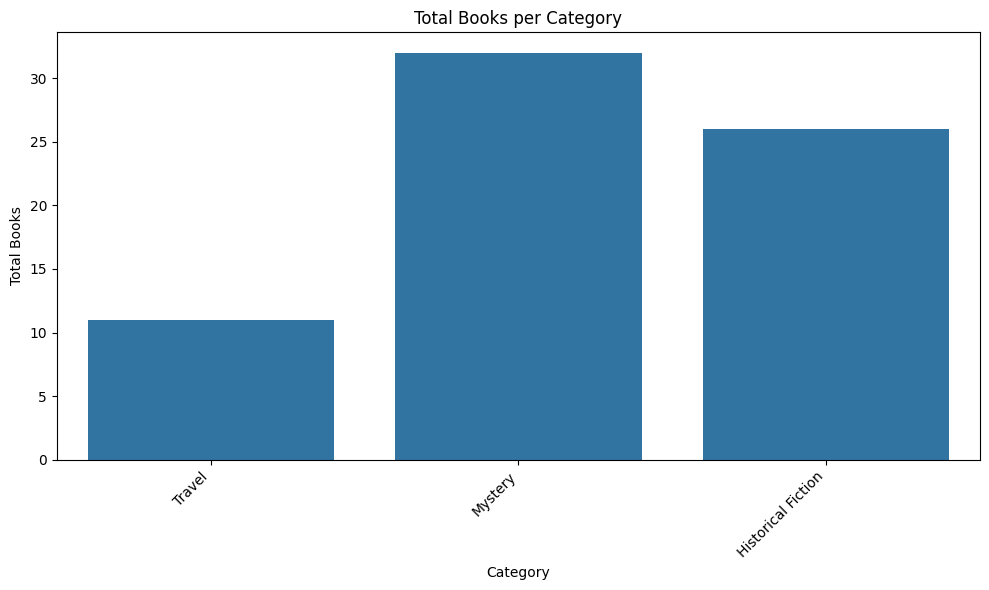

In [48]:
# Cell 2: Bar Graph - Total Books per Category
plt.figure(figsize=(10, 6))
sns.barplot(x=list(category_book_counts.keys()), y=list(category_book_counts.values()))
plt.title('Total Books per Category')
plt.xlabel('Category')
plt.ylabel('Total Books')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

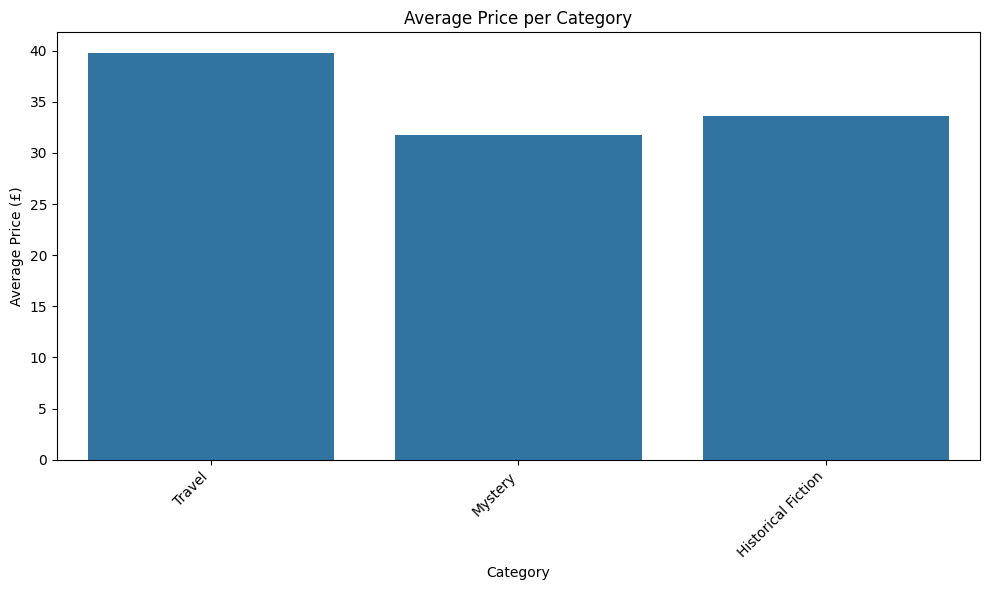

In [49]:
# Cell 3: Bar Graph - Average Price per Category
plt.figure(figsize=(10, 6))
sns.barplot(x=list(category_avg_prices.keys()), y=list(category_avg_prices.values()))
plt.title('Average Price per Category')
plt.xlabel('Category')
plt.ylabel('Average Price (£)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

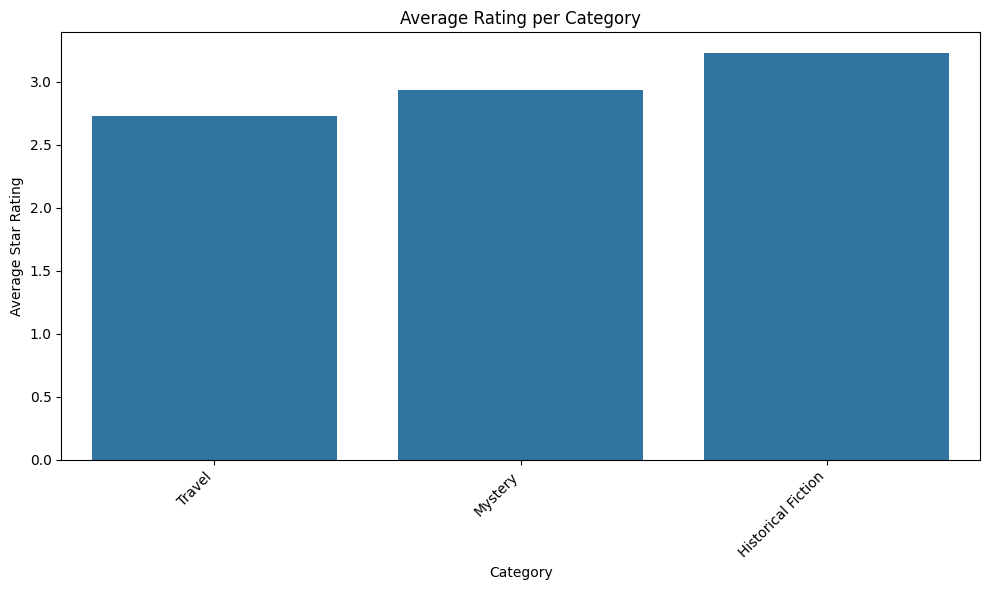

In [50]:
# Cell 4: Bar Graph - Average Rating per Category
plt.figure(figsize=(10, 6))
sns.barplot(x=list(category_ratings.keys()), y=list(category_ratings.values()))
plt.title('Average Rating per Category')
plt.xlabel('Category')
plt.ylabel('Average Star Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

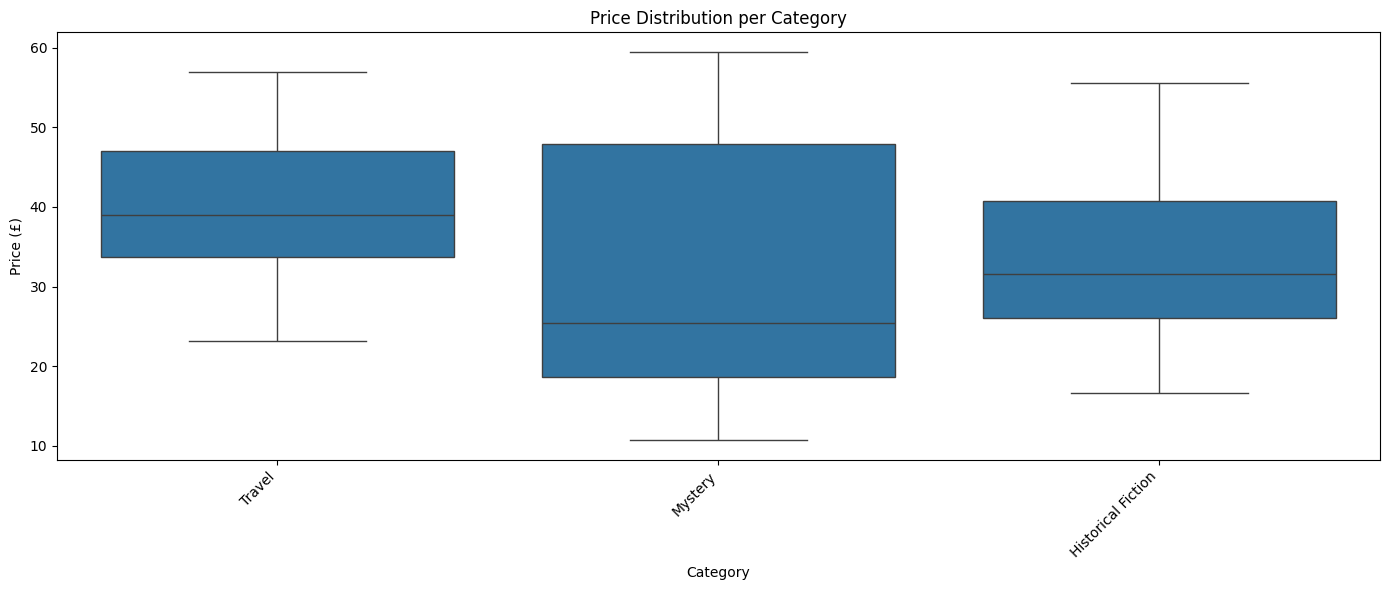

In [51]:
plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 1)
sns.boxplot(x='Category', y='Price', data=combined_df)
plt.title('Price Distribution per Category')
plt.xlabel('Category')
plt.ylabel('Price (£)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

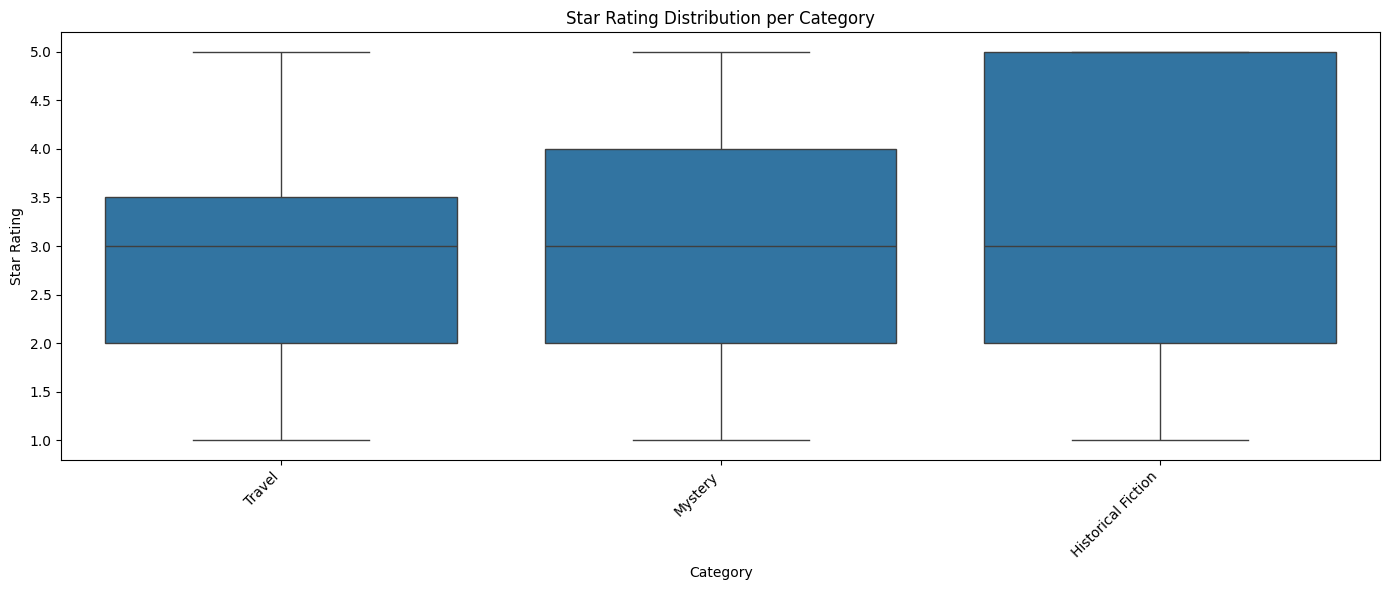

In [52]:
# Cell 5: Box Plots for Price and Rating Distributions
plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 2)
sns.boxplot(x='Category', y='Star Rating', data=combined_df)
plt.title('Star Rating Distribution per Category')
plt.xlabel('Category')
plt.ylabel('Star Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

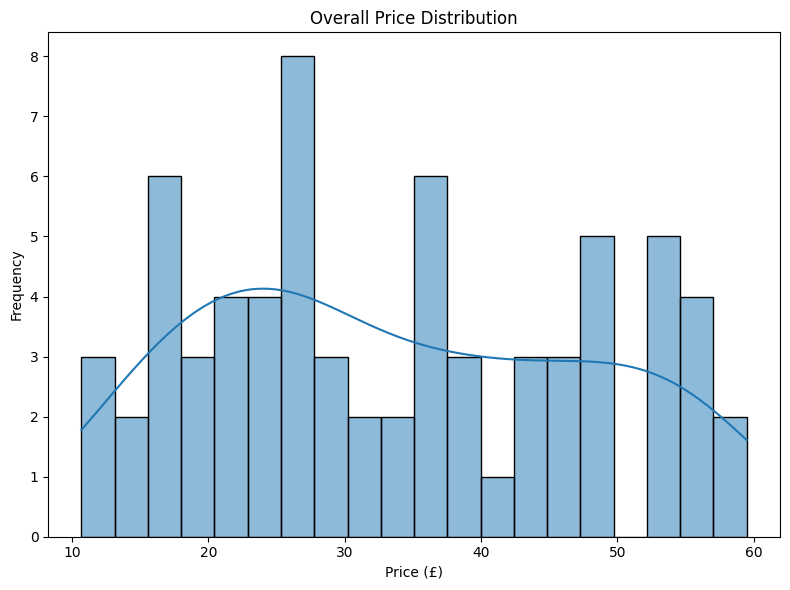

In [53]:
# Cell 6: Histogram - Overall Price Distribution
plt.figure(figsize=(8, 6))
sns.histplot(combined_df['Price'], bins=20, kde=True) # type: ignore
plt.title('Overall Price Distribution')
plt.xlabel('Price (£)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

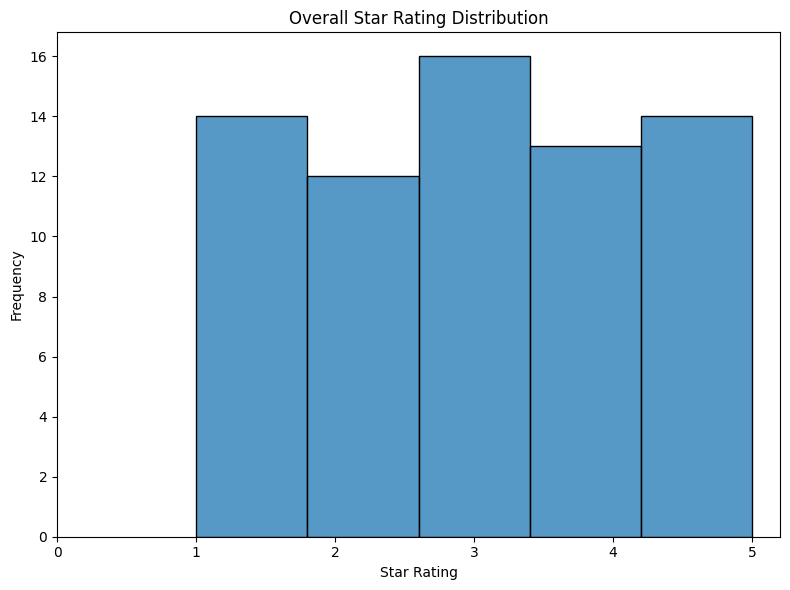

In [54]:
# Cell 7: Histogram - Overall Star Rating Distribution
plt.figure(figsize=(8, 6))
sns.histplot(combined_df['Star Rating'], bins=5, kde=False) # type: ignore
plt.title('Overall Star Rating Distribution')
plt.xlabel('Star Rating')
plt.ylabel('Frequency')
plt.xticks(range(6))
plt.tight_layout()
plt.show()

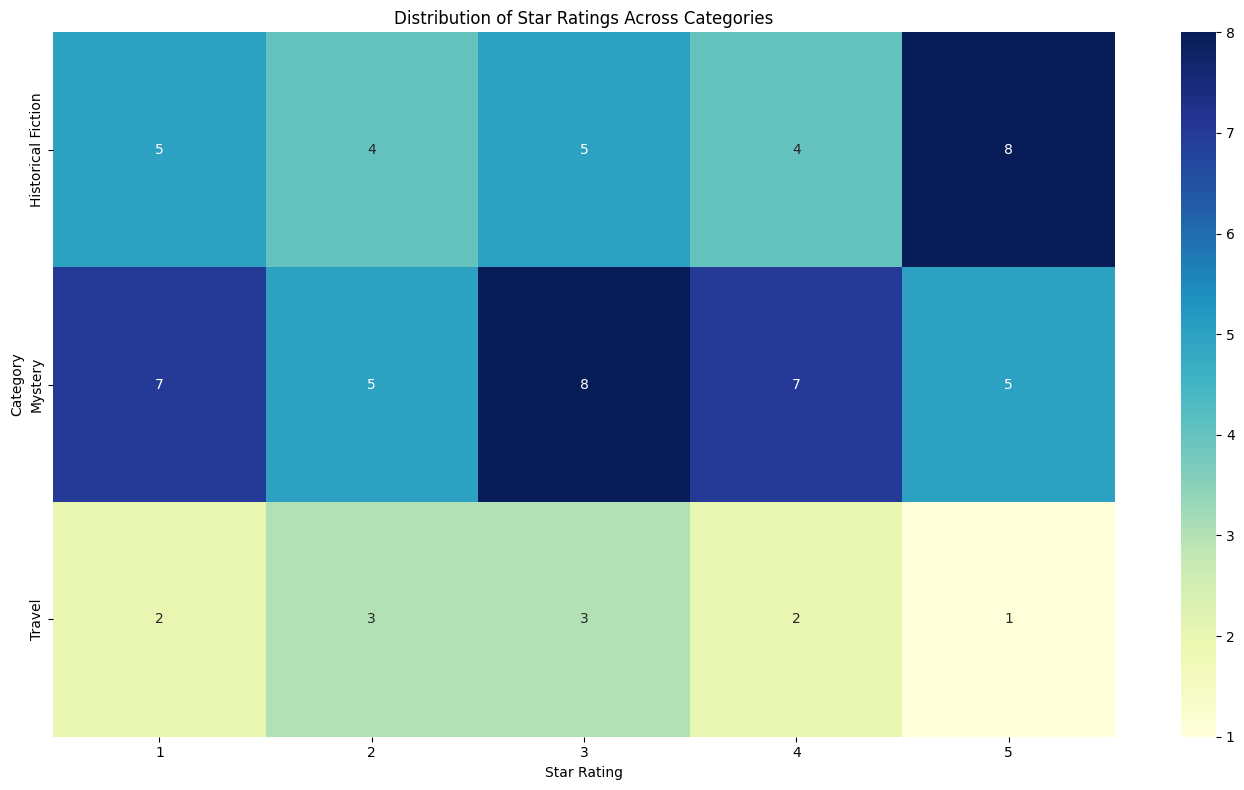

In [55]:
# Cell 8: Heatmap - Distribution of Star Ratings Across Categories
rating_category_counts = combined_df.groupby(['Category', 'Star Rating']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
sns.heatmap(rating_category_counts, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Distribution of Star Ratings Across Categories')
plt.xlabel('Star Rating')
plt.ylabel('Category')
plt.tight_layout()
plt.show()
